In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
from scipy.linalg import eigh
import pywt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

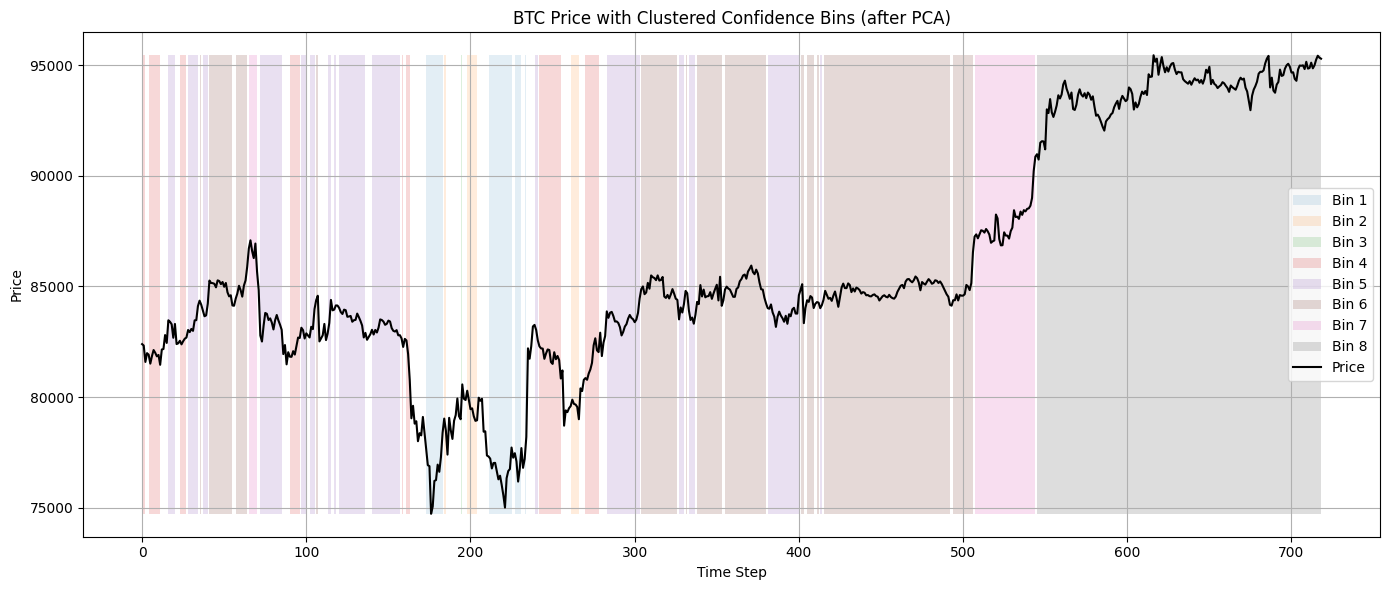

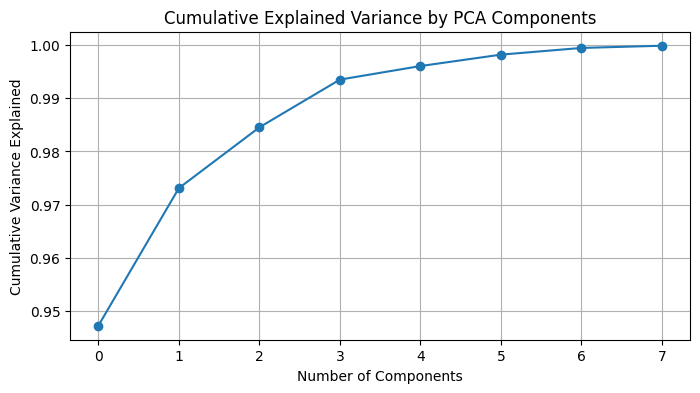

In [14]:



# Wavelet Denoising

def wavelet_denoise(signal, wavelet='db4', level=None, threshold_method='soft'):
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [coeffs[0]] + [
        pywt.threshold(c, value=uthresh, mode=threshold_method)
        for c in coeffs[1:]
    ]
    return pywt.waverec(denoised_coeffs, wavelet, mode='per')[:len(signal)]


# Marcenko-Pastur Denoising

def mp_denoise(corr_matrix, n_samples):
    n_assets = corr_matrix.shape[0]
    q = n_samples / n_assets
    lambda_plus = (1 + 1 / np.sqrt(q)) ** 2

    evals, evecs = eigh(corr_matrix)
    cleaned_evals = np.where(evals > lambda_plus, evals, 0)
    cleaned_corr = (evecs @ np.diag(cleaned_evals) @ evecs.T)
    cleaned_corr /= np.outer(np.sqrt(np.diag(cleaned_corr)), np.sqrt(np.diag(cleaned_corr)))
    return cleaned_corr


# Feature Construction (Price-Based)

def build_features(price_series, window=10):
    df = pd.DataFrame({'price': price_series})
    df['returns'] = df['price'].pct_change()
    df['momentum'] = df['price'].diff(window)
    df['volatility'] = df['returns'].rolling(window).std()
    df['sharpe'] = df['returns'].rolling(window).mean() / df['volatility']
    features = df[['momentum', 'volatility', 'sharpe']].dropna()
    return (features - features.mean()) / features.std()


# Feature Construction (OHLC)

def build_ohlc_features(df):
    vectors = []
    prev_row = None
    for _, row in df.iterrows():
        o, h, l, c = row['open'], row['high'], row['low'], row['close']
        hl_range = h - l
        oc_change = c - o
        
        if hl_range == 0:
            hl_range = 1e-8
        features = [hl_range, oc_change, c, o, h, l]
        log_features = np.log(np.abs(features) + 1e-8)
        signed_sqrt = np.sign(features) * np.sqrt(np.abs(features))

        if prev_row is None:
            prev_row = features
            prev_diff = np.zeros_like(features)
        else:
            diff = np.array(features) - np.array(prev_row)
            accel = diff - prev_diff
            frame_vector = np.concatenate([features, log_features, signed_sqrt, diff, accel])
            vectors.append(frame_vector)
            prev_row = features
            prev_diff = diff

    return np.array(vectors)


# Eigenvector Feature Extraction

def add_eigenvector_features(corr_matrix, top_k=5):
    _, evecs = eigh(corr_matrix)
    return evecs[:, -top_k:]  # shape: (features, top_k)


# KMeans Clustering into Confidence Bins

def cluster_confidence_bins(features, kmeans):
    labels = kmeans.predict(features)
    cluster_centers = kmeans.cluster_centers_[:, 0]
    ranking = np.argsort(np.argsort(cluster_centers))
    return np.array([ranking[label] + 1 for label in labels])


# Run Example and Predict Momentum


if __name__ == "__main__":
    df = pd.read_csv("btc_usd_hourly_kraken.csv", index_col='timestamp', parse_dates=True)
    df = df[['open', 'high', 'low', 'close']].dropna()

    # Build Features
    features = build_ohlc_features(df)

    # Apply PCA to reduce dimensions
    n_components = 8
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)

    # Predict Future Momentum
    future_close = df['close'].shift(-1).values[len(df) - len(features_pca):]
    current_close = df['close'].values[len(df) - len(features_pca):]
    future_momentum = (future_close - current_close) > 0

    # Cluster with KMeans
    kmeans = KMeans(n_clusters=8, random_state=42).fit(features_pca)
    bins = cluster_confidence_bins(features_pca, kmeans)

    # Align and Plot
    aligned_price = df['close'].values[-len(bins):]
    x = np.arange(len(bins))

    plt.figure(figsize=(14, 6))
    for bin_level in range(1, 9):
        mask = bins == bin_level
        plt.fill_between(x, aligned_price.min(), aligned_price.max(), where=mask, alpha=0.1 + 0.02*bin_level, label=f"Bin {bin_level}", step='mid')

    plt.plot(x, aligned_price, label='Price', color='black', linewidth=1.5)
    plt.title("BTC Price with Clustered Confidence Bins (after PCA)")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Plot PCA Explained Variance
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title("Cumulative Explained Variance by PCA Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.grid(True)
    plt.show()

In [12]:
# ─────────────────────────────────────────────────────────────────────────────
# Transition Analysis Based on Confidence Bins

num_codewords = int(bins.max()) + 1
eps = 0.01  # Neutral threshold

transition_counts = np.zeros((num_codewords, 12), dtype=int)
close_prices = df['close'].values[-len(bins):]

for t in range(len(bins) - 32):
    code_idx = bins[t] - 1  # bin levels are 1–5, index from 0

    p_t = close_prices[t]
    p_t1 = close_prices[t + 1]
    p_t2 = close_prices[t + 16]
    p_t4 = close_prices[t + 32]

    # Δp1
    delta_p1 = p_t1 - p_t
    if delta_p1 > eps:
        transition_counts[code_idx, 0] += 1
    elif delta_p1 < -eps:
        transition_counts[code_idx, 2] += 1
    else:
        transition_counts[code_idx, 1] += 1

    # Δ²p (acceleration)
    delta2_p = p_t2 - 2 * p_t1 + p_t
    if delta2_p > eps:
        transition_counts[code_idx, 3] += 1
    elif delta2_p < -eps:
        transition_counts[code_idx, 5] += 1
    else:
        transition_counts[code_idx, 4] += 1

    # Δp2
    delta_p2 = p_t2 - p_t
    if delta_p2 > eps:
        transition_counts[code_idx, 6] += 1
    elif delta_p2 < -eps:
        transition_counts[code_idx, 8] += 1
    else:
        transition_counts[code_idx, 7] += 1

    # Δp4
    delta_p4 = p_t4 - p_t
    if delta_p4 > eps:
        transition_counts[code_idx, 9] += 1
    elif delta_p4 < -eps:
        transition_counts[code_idx, 11] += 1
    else:
        transition_counts[code_idx, 10] += 1

transition_df = pd.DataFrame(
    transition_counts,
    columns=[
        'Δp1_up', 'Δp1_neutral', 'Δp1_down',
        'Δ²p_up', 'Δ²p_neutral', 'Δ²p_down',
        'Δp2_up', 'Δp2_neutral', 'Δp2_down',
        'Δp4_up', 'Δp4_neutral', 'Δp4_down'
    ],
    index=[f'bin_{i+1}' for i in range(num_codewords)]
)

print("📊 Extended Transition Summary:")
print(transition_df)


📊 Extended Transition Summary:
       Δp1_up  Δp1_neutral  Δp1_down  Δ²p_up  Δ²p_neutral  Δ²p_down  Δp2_up  \
bin_1      88            1       109      98            0       100      88   
bin_2      74            0        68      79            0        63      78   
bin_3      71            0        73      74            0        70      79   
bin_4      24            0        20      30            0        14      32   
bin_5      39            0        27      35            0        31      44   
bin_6      17            0        15      16            0        16      17   
bin_7      20            0        16      32            0         4      33   
bin_8       9            0        16      18            0         7      11   
bin_9       0            0         0       0            0         0       0   

       Δp2_neutral  Δp2_down  Δp4_up  Δp4_neutral  Δp4_down  
bin_1            0       110      95            0       103  
bin_2            0        64      83            0     

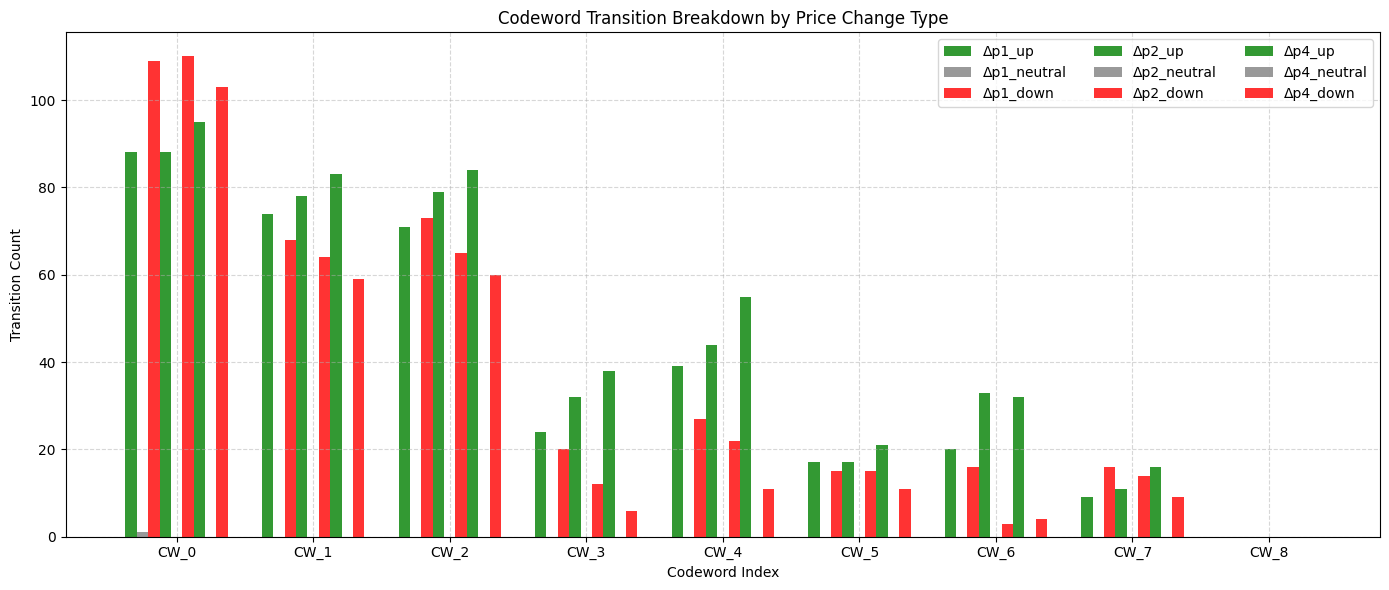

In [13]:
import matplotlib.pyplot as plt

# Set up category groupings
groups = {
    'Δp1': ['Δp1_up', 'Δp1_neutral', 'Δp1_down'],
    'Δp2': ['Δp2_up', 'Δp2_neutral', 'Δp2_down'],
    'Δp4': ['Δp4_up', 'Δp4_neutral', 'Δp4_down']
}
#     'Δ²p': ['Δ²p_up', 'Δ²p_neutral', 'Δ²p_down'],

# Bar plot setup
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(num_codewords)  # one group per codeword
bar_width = 0.25
colors = ['green', 'gray', 'red']

# Plot each group (Δp1, Δ²p, Δp2) offset on x-axis
for i, (group_label, cols) in enumerate(groups.items()):
    offset = (i - 1) * bar_width  # center groups around each x
    for j, col in enumerate(cols):
        ax.bar(x + offset + (j - 1) * (bar_width / 3), transition_df[col], 
               width=bar_width / 3, label=f'{group_label}_{["up", "neutral", "down"][j]}',
               color=colors[j], alpha=0.8)

# Labeling
ax.set_xlabel("Codeword Index")
ax.set_ylabel("Transition Count")
ax.set_title("Codeword Transition Breakdown by Price Change Type")
ax.set_xticks(x)
ax.set_xticklabels([f"CW_{i}" for i in x])
ax.legend(ncol=3)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

🟢 Bought at price 82391.80 (bin 4) at t=0
🔴 Sold at price 82800.90 (bin 5) at t=14, Profit: 409.10
🟢 Bought at price 82445.90 (bin 4) at t=15
🔴 Sold at price 83469.70 (bin 5) at t=16, Profit: 1023.80
🟢 Bought at price 83400.00 (bin 5) at t=17
🔴 Sold at price 84356.80 (bin 6) at t=35, Profit: 956.80
🟢 Bought at price 83907.10 (bin 5) at t=37
🔴 Sold at price 85266.10 (bin 6) at t=41, Profit: 1359.00
🟢 Bought at price 84126.90 (bin 5) at t=56
🔴 Sold at price 84446.10 (bin 6) at t=57, Profit: 319.20
🟢 Bought at price 82780.10 (bin 5) at t=72
🔴 Sold at price 84375.10 (bin 6) at t=106, Profit: 1595.00
🟢 Bought at price 82514.00 (bin 4) at t=108
🔴 Sold at price 83304.60 (bin 5) at t=111, Profit: 790.60
🟢 Bought at price 82572.50 (bin 4) at t=112
🔴 Sold at price 82872.00 (bin 5) at t=113, Profit: 299.50
🟢 Bought at price 83349.10 (bin 5) at t=114
🔴 Sold at price 83918.30 (bin 6) at t=116, Profit: 569.20
🟢 Bought at price 83952.10 (bin 5) at t=117
🔴 Sold at price 84137.70 (bin 6) at t=119, Prof

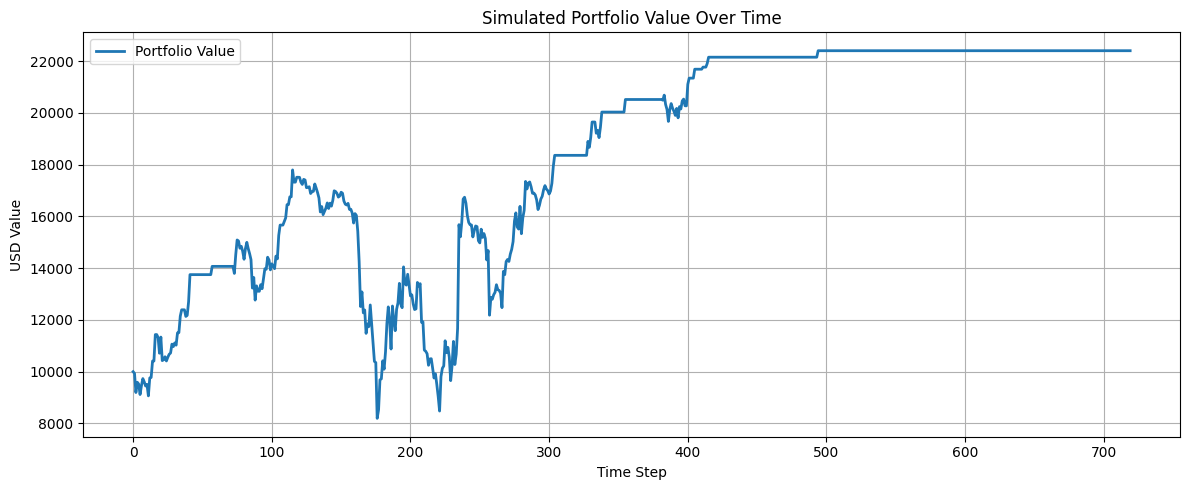

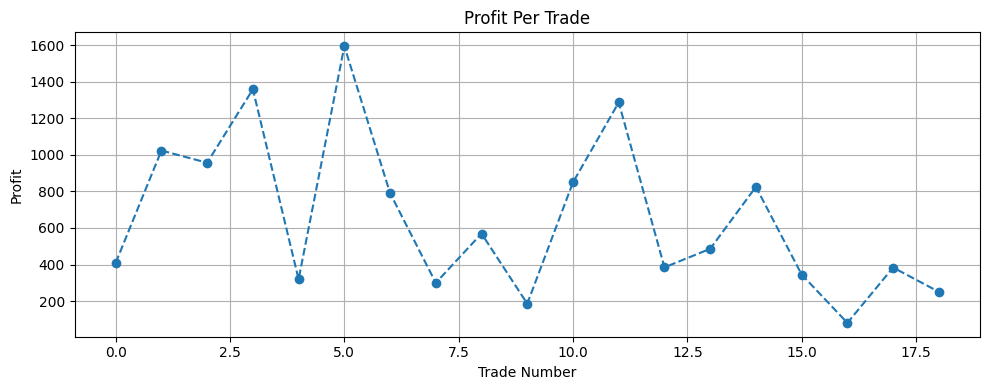

In [16]:
initial_cash = 10_000
cash = initial_cash
position_open = False
buy_price = 0
buy_bin = 0
position_size = 1.0  # how many units you buy (for now 1 BTC)

profits = []
portfolio = []
holding_value = 0





for t in range(len(bins)):
    current_bin = bins[t]
    current_price = aligned_price[t]

    # Record portfolio value (cash + unrealized)
    if position_open:
        holding_value = position_size * current_price
    else:
        holding_value = 0
    portfolio.append(cash + holding_value)

    if not position_open:
        if current_bin <= 5:
            # Buy signal
            buy_price = current_price
            buy_bin = current_bin
            position_open = True
            cash -= position_size * buy_price
            print(f"🟢 Bought at price {buy_price:.2f} (bin {buy_bin}) at t={t}")
    else:
        if current_bin > buy_bin:
            # Sell signal
            sell_price = current_price
            cash += position_size * sell_price
            profit = (sell_price - buy_price) * position_size
            profits.append(profit)
            position_open = False
            print(f"🔴 Sold at price {sell_price:.2f} (bin {current_bin}) at t={t}, Profit: {profit:.2f}")






# Force close any open position at the end
if position_open:
    final_price = aligned_price[-1]
    cash += position_size * final_price
    profit = (final_price - buy_price) * position_size
    profits.append(profit)
    print(f"⚪ Final forced sell at {final_price:.2f}, Profit: {profit:.2f}")

    holding_value = 0
    portfolio.append(cash)
else:
    portfolio.append(cash)







# Plot portfolio value over time
plt.figure(figsize=(12, 5))
plt.plot(portfolio, label='Portfolio Value', linewidth=2)
plt.title("Simulated Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("USD Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Profit per trade plot
plt.figure(figsize=(10, 4))
plt.plot(profits, marker='o', linestyle='--')
plt.title("Profit Per Trade")
plt.xlabel("Trade Number")
plt.ylabel("Profit")
plt.grid(True)
plt.tight_layout()
plt.show()
